# 使用 DPG 算法训练 Pendulum-v1 环境

欢迎来到深度确定性策略梯度（DPG）算法教程！

**DPG** 是一种用于解决连续动作空间问题的强化学习算法。它属于 Actor-Critic 框架，包含两个主要部分：
1.  **Actor (策略网络)**: 学习在给定状态下应该采取什么动作。
2.  **Critic (价值网络)**: 评估在特定状态下采取某个动作的好坏（Q值）。

在本教程中，我们将使用 PyTorch 和 Gymnasium 来训练一个智能体，使其能够成功地将一个钟摆（Pendulum）竖立起来。

## 1. 导入必要的库

首先，我们需要导入所有必需的库，包括 `gym` 用于创建环境，`torch` 用于构建和训练神经网络，以及 `numpy` 和 `random` 用于数据处理。

In [6]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
np.bool8 = np.bool_ # 新版numpy把 np.bool8 指向 np.bool_
import random
from collections import deque # 用于实现一个更高效的回放缓冲区

## 2. 定义超参数和环境

在这一步，我们定义所有训练过程中需要用到的超参数，并创建 `Pendulum-v1` 模拟环境。

- **`device`**: 指定使用 CPU 还是 GPU 进行计算。
- **`env_name`**: 我们要解决的环境名称。
- **`gamma`**: 折扣因子，用于平衡即时奖励和未来奖励的重要性。
- **`lr`**: 学习率，控制模型参数更新的幅度。
- **`batch_size`**: 每次更新时从经验回放池中采样的样本数量。
- **`max_episodes`**: 训练的总回合数。
- **`max_steps`**: 每个回合的最大步数。
- **`exploration_noise`**: 探索噪声的标准差，用于鼓励智能体探索未知的动作。

In [2]:
# 定义一些超参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env_name = "Pendulum-v1"
gamma = 0.99
lr = 0.001
batch_size = 64
max_episodes = 1000
max_steps = 200
exploration_noise = 0.1
replay_buffer_size = 10000 # 定义回放缓冲区的大小

# 创建环境
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0] # 获取动作的边界，Pendulum是[-2, 2]

print(f"Device: {device}")
print(f"State Dimension: {state_dim}")
print(f"Action Dimension: {action_dim}")
print(f"Action Bound: {action_bound}")

Device: cuda
State Dimension: 3
Action Dimension: 1
Action Bound: 2.0


## 3. 定义 Actor-Critic 网络结构

我们需要定义两个网络：
1.  **PolicyNetwork (Actor)**: 输入是环境状态 `state`，输出一个确定的动作 `action`。我们使用 `tanh`激活函数将输出缩放到 `[-1, 1]` 之间，之后再乘以 `action_bound` 映射到真实动作范围。
2.  **ValueNetwork (Critic)**: 输入是状态 `state` 和动作 `action`，输出这个状态-动作对的Q值。

In [3]:
# 定义一个策略网络 (Actor)
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # 使用 tanh 将输出缩放到 [-1, 1]，然后乘以动作边界
        x = torch.tanh(self.fc3(x)) * action_bound 
        return x


# 定义一个值函数网络 (Critic)
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1) # 拼接状态和动作
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 4. 初始化网络、优化器和回放缓冲区

现在我们来创建 Actor 和 Critic 网络的实例，并为它们分别定义优化器（这里使用 Adam）。

同时，我们创建一个 `replay_buffer`。这是一个先进先出的队列，用于存储智能体与环境交互的经验（(state, action, reward, next_state, done)元组）。从缓冲区中随机采样可以打破数据之间的相关性，使训练更稳定。

In [4]:
policy_net = PolicyNetwork(state_dim, action_dim).to(device) # 策略网络 (Actor)
value_net = ValueNetwork(state_dim, action_dim).to(device)   # 值函数网络 (Critic)

policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # 策略优化器
value_optimizer = torch.optim.Adam(value_net.parameters(), lr=lr)   # 值函数优化器

replay_buffer = deque(maxlen=replay_buffer_size) # 创建经验回放池

## 5. 开始训练

这是算法的核心部分。整个训练过程遵循以下伪代码：

```
对于每个 episode:
  重置环境，获取初始状态 s_t
  对于每个 time step t:
    1. (采样) Actor 根据 s_t 选择动作 a_t，并加入噪声增加探索
    2. (采样) 在环境中执行 a_t，获得奖励 r_t, 下一个状态 s_{t+1}, 和 done 标志
    3. (采样) 将 (s_t, a_t, r_t, s_{t+1}, done) 存入回放缓冲区
    4. (学习) 如果缓冲区数据足够：
       a. 从缓冲区随机采样一个 batch 的数据
       b. 计算目标Q值: y_i = r_i + gamma * Q_critic(s_{i+1}, a_{i+1})  (其中 a_{i+1} = mu_actor(s_{i+1}))
       c. 更新 Critic: 最小化 (y_i - Q_critic(s_i, a_i))^2
       d. 更新 Actor: 使用采样策略梯度最大化 Q_critic(s_i, mu_actor(s_i))
    5. 更新状态: s_t = s_{t+1}
    6. 如果 done，结束当前 episode
```

In [7]:
for i_episode in range(max_episodes):
    state, _ = env.reset() # 重置环境，得到初始状态
    episode_reward = 0 # 初始化回合奖励

    for t in range(max_steps):
        # --- 采样 --- #
        state_tensor = torch.as_tensor(state, dtype=torch.float32, device=device)
        action_tensor = policy_net(state_tensor) # 使用策略网络获取动作
        action = action_tensor.cpu().detach().numpy() # 将动作转换为 NumPy 数组

        # 添加一些探索噪声
        noise = np.random.normal(0, exploration_noise, size=action_dim)
        action = np.clip(action + noise, -action_bound, action_bound) # 裁剪动作确保在有效范围内

        # 在环境中执行动作, 获取下一个状态、奖励和 done 标志
        next_state, reward, done, _, _ = env.step(action)

        # 将转移存储到回放缓冲区
        replay_buffer.append((state, action, reward, next_state, done))

        # --- 更新状态和奖励 --- #
        state = next_state
        episode_reward += reward

        # --- 学习 --- #
        # 如果缓冲区中的样本数量不足一个批量，则跳过学习步骤
        if len(replay_buffer) < batch_size:
            continue

        # 从回放缓冲区中随机采样一个批量
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # 将数据转换为张量
        states = torch.as_tensor(np.array(states), dtype=torch.float32, device=device)
        actions = torch.as_tensor(np.array(actions), dtype=torch.float32, device=device)
        rewards = torch.as_tensor(np.array(rewards), dtype=torch.float32, device=device).unsqueeze(-1)
        next_states = torch.as_tensor(np.array(next_states), dtype=torch.float32, device=device)
        dones = torch.as_tensor(np.array(dones), dtype=torch.float32, device=device).unsqueeze(-1)

        # --- 更新 Critic 网络 ---
        with torch.no_grad():
            next_actions = policy_net(next_states)
            next_q_values = value_net(next_states, next_actions)
            # 计算目标Q值
            target_q_values = rewards + (1 - dones) * gamma * next_q_values

        current_q_values = value_net(states, actions)
        value_loss = F.mse_loss(current_q_values, target_q_values)

        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        # --- 更新 Actor 网络 ---
        # 我们希望最大化Q值，等价于最小化负Q值
        policy_loss = -value_net(states, policy_net(states)).mean()

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # 如果 done 标志为 True，结束当前 episode
        if done:
            break
    
    if (i_episode + 1) % 10 == 0:
        print(f"Episode: {i_episode+1}, Reward: {episode_reward:.2f}")

Episode: 10, Reward: -1264.65
Episode: 20, Reward: -1386.87
Episode: 30, Reward: -1409.72
Episode: 40, Reward: -1237.97
Episode: 50, Reward: -1490.11
Episode: 60, Reward: -1589.67
Episode: 70, Reward: -1498.39
Episode: 80, Reward: -1369.36
Episode: 90, Reward: -1514.46
Episode: 100, Reward: -1623.37
Episode: 110, Reward: -1612.75
Episode: 120, Reward: -1502.55
Episode: 130, Reward: -721.32
Episode: 140, Reward: -1516.93
Episode: 150, Reward: -1488.64
Episode: 160, Reward: -1186.24
Episode: 170, Reward: -1570.93
Episode: 180, Reward: -1528.55
Episode: 190, Reward: -1646.99
Episode: 200, Reward: -1575.23
Episode: 210, Reward: -1295.21
Episode: 220, Reward: -1577.01
Episode: 230, Reward: -1410.45
Episode: 240, Reward: -1121.44
Episode: 250, Reward: -1170.21
Episode: 260, Reward: -1651.39
Episode: 270, Reward: -1670.43
Episode: 280, Reward: -835.61
Episode: 290, Reward: -1486.36
Episode: 300, Reward: -1397.38
Episode: 310, Reward: -1671.44
Episode: 320, Reward: -1176.03
Episode: 330, Rewar

## 6. 总结与展望

恭喜！您已经成功地使用 DPG 算法实现并训练了一个强化学习智能体。

**可以尝试的改进方向：**
1.  **DDPG**: 您当前实现的是 DPG 的一个基础版本。可以引入目标网络（Target Networks）来升级为 DDPG（Deep Deterministic Policy Gradient），这可以大大增加训练的稳定性。
2.  **超参数调优**: 尝试调整学习率 `lr`、`batch_size`、`gamma` 等超参数，观察它们对训练结果的影响。
3.  **网络结构**: 尝试更深或更宽的神经网络，看看是否能提升性能。
4.  **评估**: 在训练结束后，可以编写一个独立的评估函数，在没有探索噪声的情况下测试智能体的表现。

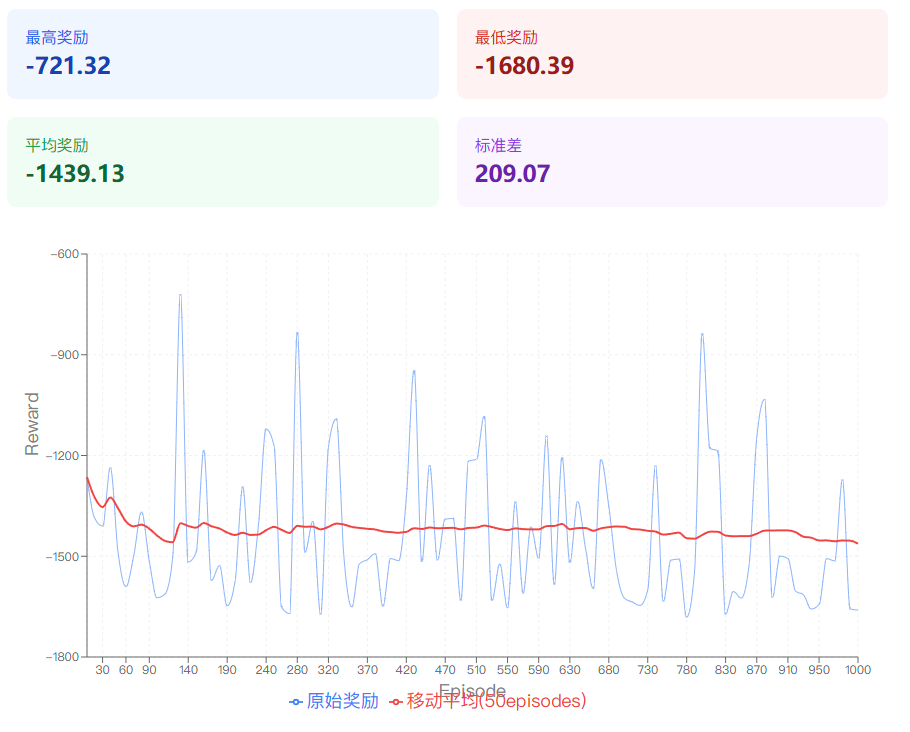

训练分析总结

观察到的问题：
- 奖励值始终为负，未显示学习进步
- 高方差(σ=209.07)表明训练不稳定
- 移动平均线基本平坦，无明显上升趋势
- 偶有突破但无法维持

可能的改进方向：

- 调整学习率和探索策略
- 检查奖励函数设计
- 增加经验回放缓冲区大小
- 考虑使用不同的网络结构